In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline


In [3]:
CLIENTS_PATH = 'data.csv'
TARGET = 'Credit Default'

TREATMENT_NAME = 'treatment'
TARGET_NAME = 'target'

SELECTED_FEATURE_NAMES= ['recency', 
                         'history',
                         'used_discount',
                         'used_bogo',
                         #'zip_code',           # класс местности Пригородный/Городской/Сельский
                         'zip_code__cat',
                         'is_referral',
                         #'channel'             # канал который использует покупатель Телефон/Интернет/Многоканальный
                         'channel__cat'
                        ]

cat_features = ['used_discount',    # использование дискаунта раньше
                'used_bogo',        # использовал ли покупку раньше
                'zip_code__cat',         # класс местности Пригородный/Городской/Сельский
                'is_referral',      # был ли клиент приобретен через реферальный канал
                'channel__cat'           # канал который использует покупатель Телефон/Интернет/Многоканальный
]

In [4]:
# загрузка набора данных маркетинговых кампаний
df_clients = pd.read_csv(CLIENTS_PATH)

In [5]:
# переименовать поля
df_clients = df_clients.rename(columns={
    'offer':TREATMENT_NAME, 
    'conversion':TARGET_NAME})

In [6]:
# приводим поле treatment к бинарному виду
df_clients[TREATMENT_NAME] = df_clients[TREATMENT_NAME].map({'No Offer':False}).astype(bool)


In [7]:
df_clients[TREATMENT_NAME].value_counts()
# похоже данные немного не сбалансированы

True     42694
False    21306
Name: treatment, dtype: int64

In [8]:
# настройка категориальных признаков если такие имеются
df_clients['zip_code__cat'] = df_clients['zip_code'].map({
    'Surburban':1, 
    'Urban':2, 
    'Rural':3
    }).astype(int)
df_clients['channel__cat'] = df_clients['channel'].map({
    'Web':1, 
    'Phone':2, 
    'Multichannel':3
    }).astype(int)

In [9]:
# сделать разбиение набора данных на тренировочную и тестовую выборки
X = df_clients[SELECTED_FEATURE_NAMES]      # признаки о клиенте
y = df_clients[TARGET_NAME]                 # целевой признак
treat = df_clients[TREATMENT_NAME]          # те на кого была произведена маркетинговая кампания 

X_train, X_valid, y_train, y_valid, treat_train, treat_valid = train_test_split(X, y, treat, test_size=0.30, random_state=21)

In [10]:
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

# сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)


In [11]:
from sklearn.utils.validation import check_consistent_length

In [12]:
# провести uplift-моделирование 3 способами: 
# одна модель с признаком коммуникации (S learner), 
# модель с трансформацией таргета (трансформация классов п. 2. 1) 
# вариант с двумя независимыми моделями

## Uplift-моделирование S learner

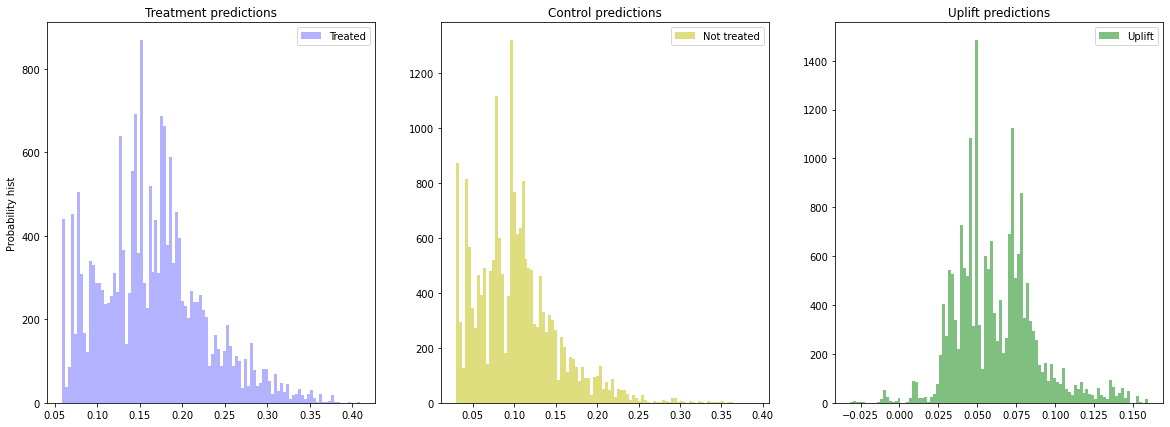

In [13]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# воспользуемся catboost
from catboost import CatBoostClassifier

N =20000
sm = SoloModel(  CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(  X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)
sm_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(   sm.trmnt_preds_ , sm.ctrl_preds_, bins=100);

In [14]:
# топ признаки
pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,treatment,21.907619
1,is_referral,20.888463
2,used_bogo,12.325199
3,zip_code__cat,11.518851
4,recency,10.804377
5,used_discount,8.397037
6,history,8.193585
7,channel__cat,5.964868


In [15]:
# таблица по процентилям
from sklift.metrics import uplift_by_percentile


uplift_by_percentile(y_valid, uplift_sm, treat_valid, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1278,642,0.269953,0.155763,0.114190,0.012418,0.014312,0.018948
10-20,1295,625,0.198456,0.128000,0.070456,0.011083,0.013364,0.017361
20-30,1292,628,0.186533,0.127389,0.059144,0.010837,0.013304,0.017160
30-40,1284,636,0.169003,0.138365,0.030638,0.010458,0.013691,0.017229
40-50,1311,609,0.168574,0.144499,0.024074,0.010340,0.014247,0.017604
50-60,1293,627,0.175561,0.100478,0.075082,0.010580,0.012006,0.016003
60-70,1260,660,0.139683,0.078788,0.060895,0.009766,0.010487,0.014330
70-80,1279,641,0.135262,0.095164,0.040098,0.009563,0.011590,0.015026
80-90,1297,623,0.114880,0.080257,0.034624,0.008854,0.010885,0.014031


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0543'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

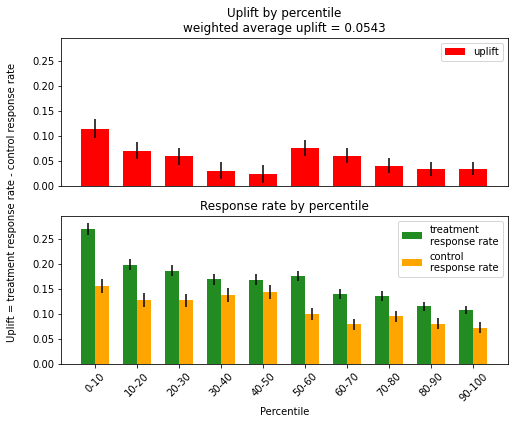

In [16]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_sm, treat_valid, 
                          strategy='overall', kind='bar');


## Модель с трансформацией таргета

In [17]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_valid)

ct_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)


<ipython-input-17-9050a9eb14c8>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


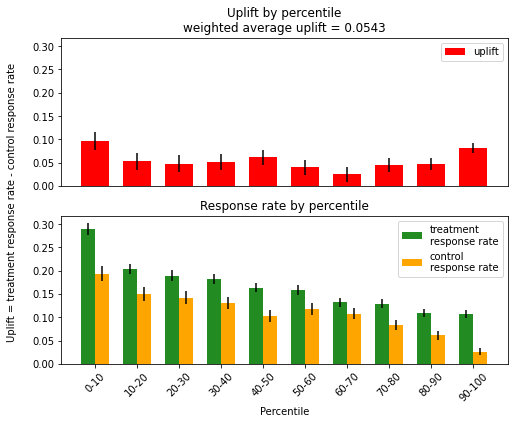

In [18]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_ct, treat_valid, 
                          strategy='overall', kind='bar');

## Вариант с двумя независимыми моделями

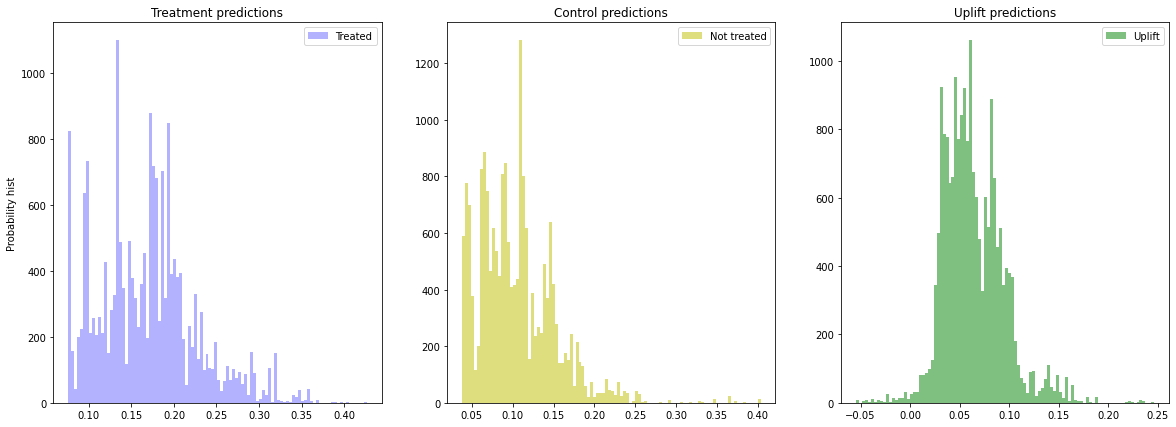

In [19]:
from sklift.models import TwoModels


tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_valid)

tm_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

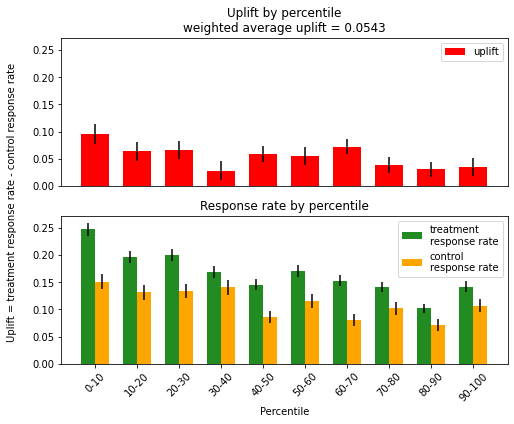

In [21]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_tm, treat_valid, strategy='overall', kind='bar');

In [20]:
# Сравнение трех моделей по результатам метрик
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.113925,0.091932
1,ClassTransformation,0.095964,0.073746
2,TwoModels,0.095478,0.078735


## Модель с деревом решений

In [ ]:
# модель с деревом решений